<a href="https://colab.research.google.com/github/kariajh/Salarios_IT_2022/blob/main/An%C3%A1lisis_salario_IT_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analisis de salario mensual neto**

Muchos salarios ingresados no se corresponden necesariamente con datos reales. Esto puede ser debido a errores de tipeo, no entendimiento de la pregunta, o simplemente intencionales. Para evitar que estos valores distorsionen resultados, aplicamos la medida estadistica percentil para analizar valores extremos minimos y maximos. Se toma en cuenta el salario minimo para eliminar extremos minimos.

# Librerias

In [ ]:
# Tratamiento de datos
import numpy as np
import pandas as pd
from tabulate import tabulate
import io
import scipy

# Gráficos
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm

# Configuración matplotlib
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
import warnings
warnings.filterwarnings('ignore')

# Datos

Se trabajará con la Encuesta Sysarmy del año 2022. Se trata de una encuesta personal y voluntaria que busca relevar información sobre salarios y condiciones de trabajo de programadores, que se realiza anualmente.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sysarmy_survey_2022_processed.csv to sysarmy_survey_2022_processed.csv


In [ ]:
file_key = 'sysarmy_survey_2022_processed.csv'
df = pd.read_csv(io.StringIO(uploaded[file_key].decode('utf-8')))

In [ ]:
df[:2]

,work_country,work_province,work_dedication,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,numero,salary_in_usd,salary_last_dollar_value,salary_pay_cripto,...,profile_studies_level_state,profile_career,profile_university,profile_boot_camp,profile_boot_camp_carrer,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,profile_age,profile_gender
0,Argentina,Catamarca,Full-Time,Staff (planta permanente),300000.0,245000.0,True,NaN,NaN,NaN,...,Completo,Licenciatura en redes y comunicación de datos,UP - Universidad de Palermo,NaN,NaN,NaN,NaN,NaN,35,Varón Cis
1,Argentina,Chaco,Full-Time,Remoto (empresa de otro país),900000.0,850000.0,True,Cobro todo el salario en dólares,300,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,Varón Cis


In [ ]:
# Tipo de cada columna
# En pandas, el tipo "object" hace referencia a strings
# datos.dtypes
df[['salary_monthly_NETO', 'salary_monthly_BRUTO']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5358 entries, 0 to 5357
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   salary_monthly_NETO   5358 non-null   float64
 1   salary_monthly_BRUTO  5358 non-null   float64
dtypes: float64(2)
memory usage: 83.8 KB


# **Estadistica descriptiva**

El uso de visualizaciones nos limita a estimaciones, pero los datos crudos son demasiado como para intepretarlos en conjunto. Para eso, la estadística descriptiva provee también medidas de tendencia central y de dispersión, que resumen en un valor numérico propiedades de las realizaciones de la variable.

# Medidas de tendencia central

In [ ]:
#mean:media muestral (aritmética) o promedio
#mediana: medida de posicion central
#moda: es el valor que aparece con mayor frecuencia
pd.set_option('display.float_format',lambda x: '%.2f' % x)
print('Media: ',df['salary_monthly_NETO'].mean())
print('Mediana: ',df['salary_monthly_NETO'].median())
print('Moda: ', df['salary_monthly_NETO'].mode())

Media:  277010.78680309816
Mediana:  201000.0
Moda:  0   0.00
Name: salary_monthly_NETO, dtype: float64


¿Por qué las dos primeras medidas son tan distintas?

*  La media se puede interpretar como el centro de masa del histograma.
*  La media es muy sensible a valores extremos.
*  La mediana es más robusta a valores extremos.

Si la distribución de los datos es simétrica, las medidas coinciden. (Luego, si no coinciden es porque la distribución no es simétrica)

Respecto de la moda

La moda revela que el valor que mas se repite es el cero,  para evitar distorsiones debido a valores demasiado bajos, conviene eliminar todas aquellas entradas cuyo salario sea menor al salario mínimo.

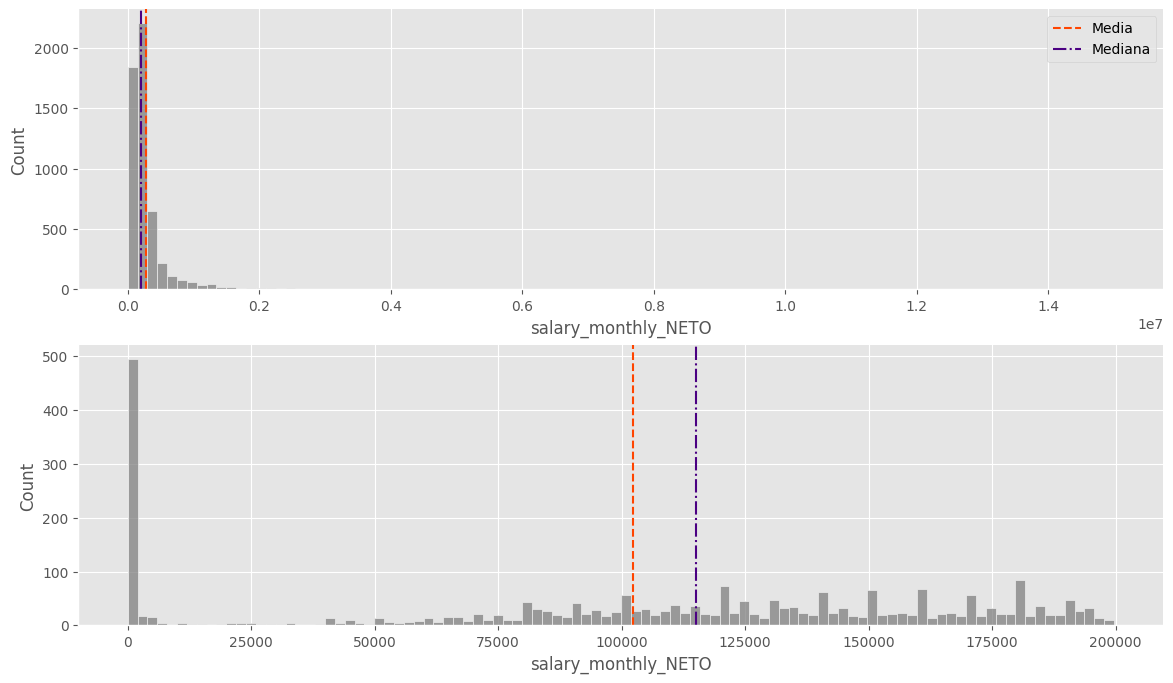

In [ ]:
## La diferencia no siempre se aprecia en los gráficos
fig, axes = plt.subplots(nrows=2, figsize=(14, 8))
#plt.ticklabel_format(style='plain', axis='x')
sns.histplot(df['salary_monthly_NETO'], bins=100, ax=axes[0], color='gray')
axes[0].axvline(df['salary_monthly_NETO'].mean(), color='orangered',
            linestyle='--', label='Media')
axes[0].axvline(df['salary_monthly_NETO'].median(), color='indigo',
            linestyle='-.', label='Mediana')
## Filtramos los valores por debajo de 200000 pesos
filtered_df = df[df['salary_monthly_NETO'] < 200000]
sns.histplot(filtered_df['salary_monthly_NETO'], bins=100, ax=axes[1], color='gray')
axes[1].axvline(filtered_df['salary_monthly_NETO'].mean(), color='orangered',
            linestyle='--', label='Media')
axes[1].axvline(filtered_df['salary_monthly_NETO'].median(), color='indigo',
            linestyle='-.', label='Mediana')

axes[0].legend()
sns.despine()

La variable salary_monthly_NETO tiene una distribución asimétrica con una cola positiva debido a que, unas pocos salarios, tienen un precio muy superior a la media. Este tipo de distribución suele visualizarse mejor tras aplicar el logarítmica o la raíz cuadrada.

# Medidas de dispersión

Las medidas de dispersión son la desviación estándar, la varianza, y el coeficiente de variación. También permiten representar con un número alguna propiedad de los datos.

Por ejemplo, comparemos el salario neto con el salario bruto. A priori, ¿deberíamos ver alguna diferencia?

In [ ]:
df[['salary_monthly_NETO', 'salary_monthly_BRUTO']].describe().round()

,salary_monthly_NETO,salary_monthly_BRUTO
count,5358.00,5358.00
mean,277011.00,363511.00
std,401942.00,543925.00
min,0.00,0.00
25%,118612.00,150000.00
50%,201000.00,256000.00
75%,294000.00,412657.00
max,15000000.00,28000000.00


Claramente, ambas distribuciones están centradas en valores distintos, pero ¿podemos decir algo sobre su dispersión?

Cuando se comparan dos características diferentes (que pueden tener magnitudes diferentes) puede no ser conveniente comparar directamente los valores de las desviaciones estándar, sino que podemos usar el coeficiente de variación (desviación estándar dividida la media).

In [ ]:
print("Coeficiente de variación salario bruto",
      scipy.stats.variation(df.salary_monthly_BRUTO))
print("Coeficiente de variación salario neto",
      scipy.stats.variation(df.salary_monthly_NETO.dropna()))

Coeficiente de variación salario bruto 1.4961731068408217
Coeficiente de variación salario neto 1.450863314811162


# Eliminación de valores extremos

**Usando percentiles**

Una forma conservadora de eliminar valores extremos que estén afectando a la media, el rango y las visualizaciones es seleccionar un cierto porcentaje más extremo. Para eso, usamos los percentiles.

Podemos calcular los percentiles en ambos extremos de los registros para decidir cuales serían los más apropiados.

Percentil K 10

In [ ]:
k =10
percentil_10 = df['salary_monthly_NETO'].quantile(10 / 100)
n_below = len(df[df['salary_monthly_NETO'] < percentil_10])
n_above = len(df[df['salary_monthly_NETO'] > percentil_10])
print('Percentil {} de la columna {}: {}'.format(k, 'salary_monthly_NETO', percentil_10))
print('% de datos menor que percentil {}: {}'.format(k, n_below / len(df)))
print('% de datos mayor que percentil {}: {}'.format(k, n_above / len(df)))

Percentil 10 de la columna salary_monthly_NETO: 10350.000000000022
% de datos menor que percentil 10: 0.10003732736095558
% de datos mayor que percentil 10: 0.8999626726390444


In [ ]:
df['salary_monthly_NETO'].quantile([.15, .18, .19, .195, .198])

0.15    80000.00
0.18    92394.92
0.19    97000.00
0.20    99600.00
0.20   100000.00
Name: salary_monthly_NETO, dtype: float64

Eliminamos los valores extremos por debajo del salario minimo aproximadamente.

In [ ]:
min_limit = df['salary_monthly_NETO'].quantile(.19)
df=df[df['salary_monthly_NETO'] > min_limit]
df.shape

(4335, 44)

Eliminando los valores extremos de los valores minimos, se modifican la medidas de tendencia central.

In [ ]:
print('Media: ',df['salary_monthly_NETO'].mean())
print('Mediana: ',df['salary_monthly_NETO'].median())
print('Moda: ', df['salary_monthly_NETO'].mode())

Media:  334261.5041014994
Mediana:  230000.0
Moda:  0   250000.00
Name: salary_monthly_NETO, dtype: float64


Analizamos los sueldos que superan a la media.

Percentil K 90

In [ ]:
k = 90
percentile_90 = df['salary_monthly_NETO'].quantile(k / 100)
n_below = len(df[df['salary_monthly_NETO'] < percentile_90])
n_above = len(df[df['salary_monthly_NETO'] > percentile_90])
print('Percentil {} de la columna {}: {}'.format(k, 'salary_monthly_NETO', percentile_90))
print('% de datos menor que percentil {}: {}'.format(k, n_below / len(df)))
print('% de datos mayor que percentil {}: {}'.format(k, n_above / len(df)))

Percentil 90 de la columna salary_monthly_NETO: 600000.0
% de datos menor que percentil 90: 0.8975778546712803
% de datos mayor que percentil 90: 0.09642445213379469


In [ ]:
df['salary_monthly_NETO'].quantile([.95, .98, .99, .995, .998])

0.95   1000000.00
0.98   1500000.00
0.99   2000000.00
0.99   2400000.00
1.00   2733200.00
Name: salary_monthly_NETO, dtype: float64

# Graficos 

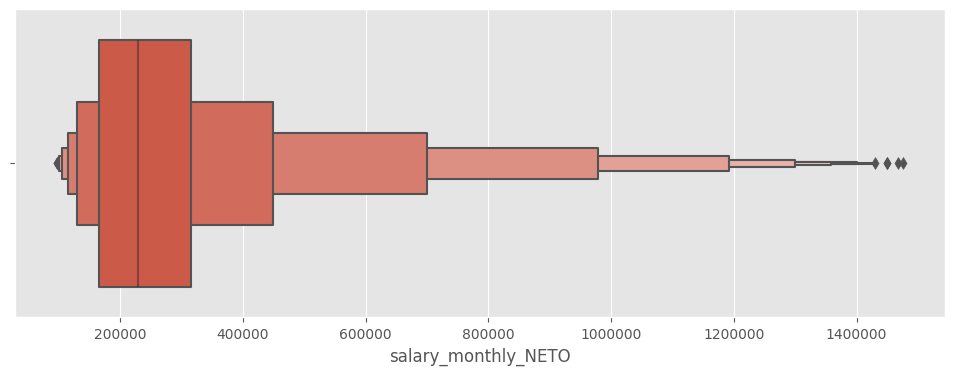

In [ ]:
#Grafico
plt.figure(figsize=(12, 4))
max_limit = df['salary_monthly_NETO'].quantile(.98)
sns.boxenplot(x=df[df['salary_monthly_NETO'] < max_limit]['salary_monthly_NETO'])
plt.ticklabel_format(style='plain', axis='x')

<Axes: xlabel='salary_monthly_NETO'>

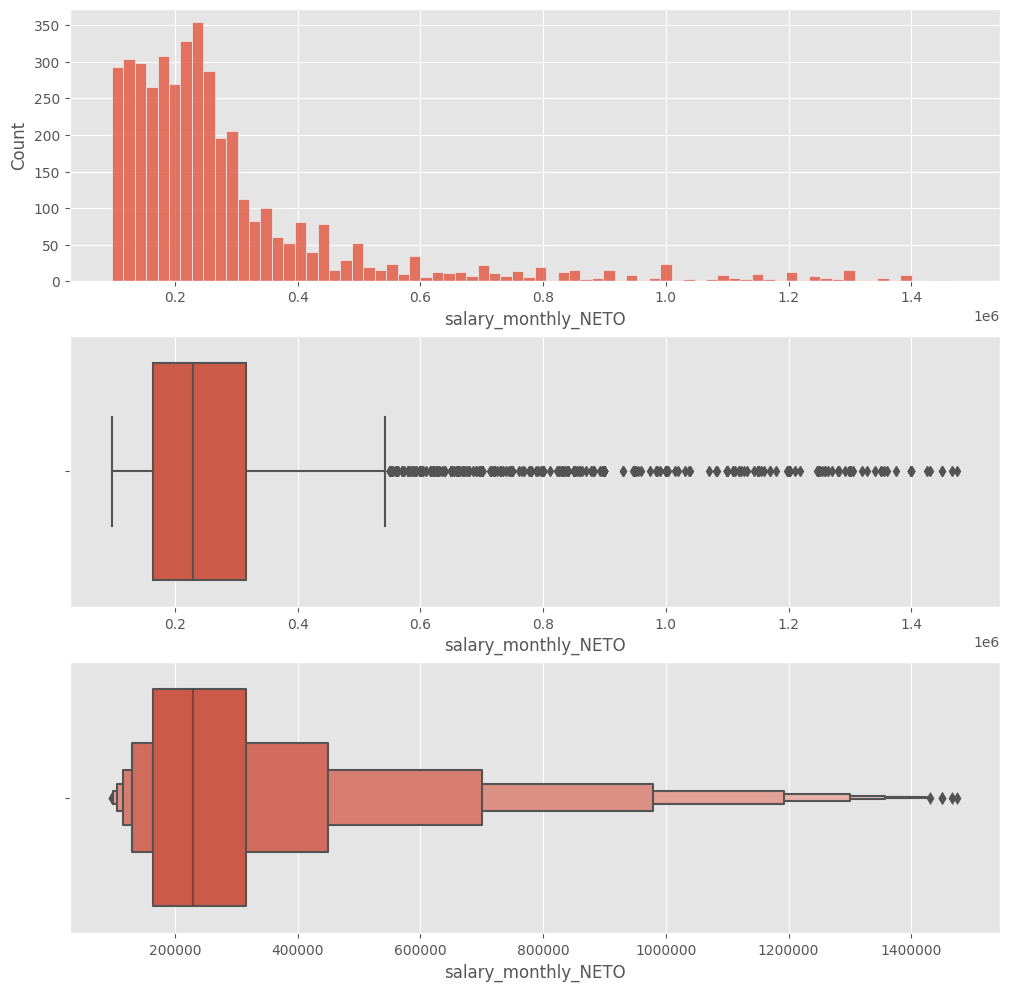

In [ ]:
fig, axes = plt.subplots(figsize=(12, 12), nrows=3)
plt.ticklabel_format(style='plain', axis='x')
max_limit = df['salary_monthly_NETO'].quantile(.98)
data = df[df['salary_monthly_NETO'] < max_limit]['salary_monthly_NETO']
sns.histplot(x=data, ax=axes[0])
sns.boxplot(x=data, ax=axes[1])
sns.boxenplot(x=data, ax=axes[2])


¿Quiénes son los que cobran tanto?

In [ ]:
df[df['salary_monthly_NETO'] > df['salary_monthly_NETO'].quantile(0.98)]


,work_country,work_province,work_dedication,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,numero,salary_in_usd,salary_last_dollar_value,salary_pay_cripto,...,profile_studies_level_state,profile_career,profile_university,profile_boot_camp,profile_boot_camp_carrer,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,profile_age,profile_gender
87,Argentina,Ciudad Autónoma de Buenos Aires,Full-Time,Freelance,1700000.00,1700000.00,True,Cobro todo el salario en dólares,350,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30,Varón Trans
178,Argentina,Ciudad Autónoma de Buenos Aires,Full-Time,Remoto (empresa de otro país),1800000.00,1750000.00,True,Cobro todo el salario en dólares,230,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44,Varón Cis
266,Argentina,Ciudad Autónoma de Buenos Aires,Full-Time,Remoto (empresa de otro país),2000000.00,1900000.00,True,Cobro todo el salario en dólares,NaN,NaN,...,En curso,Diseño Gráfico,UBA - Universidad de Buenos Aires,NaN,NaN,No,0.00,Porcentaje de mi sueldo bruto,23,Varón Cis
283,Argentina,Ciudad Autónoma de Buenos Aires,Full-Time,Remoto (empresa de otro país),2000000.00,1800000.00,True,Cobro todo el salario en dólares,NaN,NaN,...,Completo,Ingeniería en Sistemas de Información,UTN - Universidad Tecnológica Nacional,NaN,NaN,NaN,NaN,NaN,25,Varón Cis
356,Argentina,Ciudad Autónoma de Buenos Aires,Full-Time,Staff (planta permanente),1751000.00,1751000.00,True,Cobro todo el salario en dólares,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,Varón Cis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5181,Argentina,Santa Fe,Full-Time,Remoto (empresa de otro país),2400000.00,2000000.00,True,Cobro todo el salario en dólares,NaN,NaN,...,Completo,Analista de Sistemas,NaN,No,NaN,"Sí, activa",50.00,Porcentaje de mi sueldo bruto,40,Varón Cis
5184,Argentina,Santa Fe,Full-Time,Remoto (empresa de otro país),2300000.00,2000000.00,True,Cobro todo el salario en dólares,NaN,NaN,...,Completo,Licenciatura en Informática,Universidad Siglo 21,NaN,NaN,No,0.00,Porcentaje de mi sueldo bruto,42,Varón Cis
5185,Argentina,Santa Fe,Full-Time,Staff (planta permanente),1600000.00,1600000.00,True,Cobro todo el salario en dólares,NaN,Cobro todo el salario criptomonedas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27,Varón Cis
5186,Argentina,Santa Fe,Full-Time,Tercerizado (trabajo a través de consultora o ...,2520000.00,2520000.00,True,Cobro todo el salario en dólares,NaN,Cobro todo el salario criptomonedas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,Varón Cis


# Posiciones que mas cobran

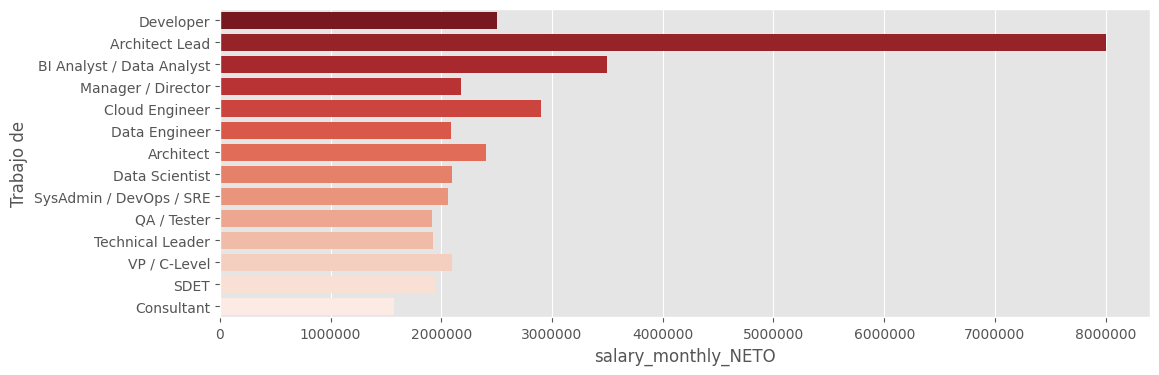

In [ ]:
plt.figure(figsize=(12, 4))
sns.barplot(data=df[df['salary_monthly_NETO'] > max_limit].sort_values('salary_monthly_NETO',ascending=False),y='Trabajo de',x='salary_monthly_NETO',errorbar=None,palette= "Reds_r")
plt.ticklabel_format(style='plain', axis='x')

# Tipos de contratos de los que mas cobran

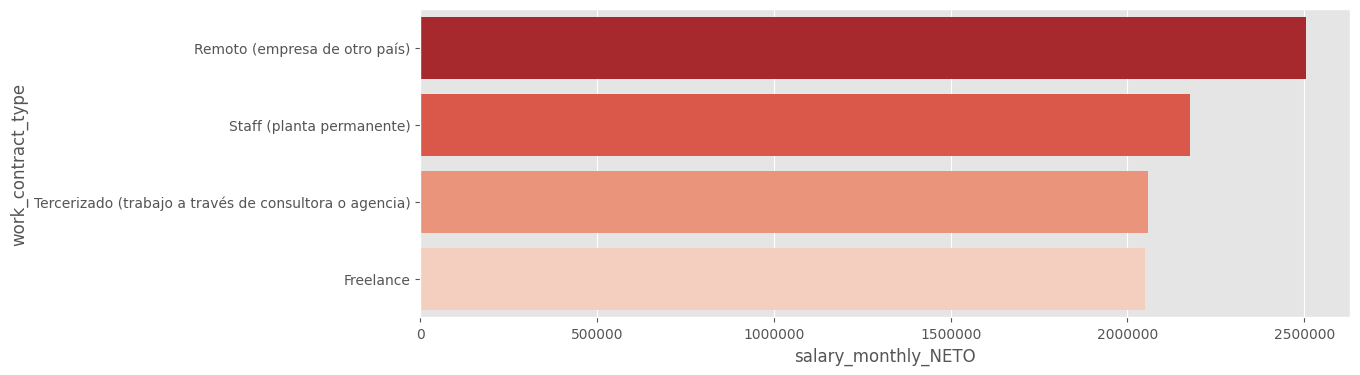

In [ ]:
plt.figure(figsize=(12, 4))
sns.barplot(data=df[df['salary_monthly_NETO'] > max_limit].sort_values('salary_monthly_NETO',ascending=False),y='work_contract_type',x='salary_monthly_NETO',errorbar=None,palette= "Reds_r")
plt.ticklabel_format(style='plain', axis='x')